In [1]:
import pandas as pd 
import os
import matplotlib.pyplot as plt
import json
import mne
import numpy as np
from tqdm import tqdm
import re
from multiprocessing import Pool
import warnings

warnings.filterwarnings("ignore")

os.chdir('../..')

# Load All The Exec Blocks

In [2]:
from Scripts.Data_Loader import EIRDataset

EIR_Dataset = EIRDataset('./Generated/Data_Train/', task_type='all', n_jobs=72) # task type can be `geometric` or `random` or `all`

# Get the sample of data
for i in range(len(EIR_Dataset)): 
    eeg_sample, eye_sample, metadata, label, img = EIR_Dataset[i]
    print(f"EEG sample len is: {len(eeg_sample)}")
    break

Loading .fif files: 100%|██████████| 651/651 [00:29<00:00, 22.30it/s]


EEG sample len is: 16001


# Compute Morlet Wavelet Spectrums for Execution Blocks 
As a result, produces:
* `psds_array` - list of psds morlet wavelet spectras
* `metadata`   - list of [`sub_id`, `trial_id`, `gender`, `handiness`, `age`, ...] 

### Get the subjects info
Will be usefull to pack ones for spectrums 

In [3]:
from datetime import datetime

# --- 1) Читаем Excel, пропуская первую строку «слитного» заголовка ---
file_path = './Supplementary/Experiment_Metadata.xlsx'
df_raw = pd.read_excel(file_path, header=1)

# --- 2) Переименовываем нужные колонки ---
df_raw = df_raw.rename(columns={
    'Subject ID'         : 'Subject_id',
    'Имя'                : 'Name',
    'Фамилия'            : 'Surname',
    'Дата Рождения'      : 'Birthdate',
    'Пол'                : 'Gender',
    'Правша / Левша'     : 'Handiness',
})

# --- 3) Оставляем только нужные поля, включая Handiness ---
df = df_raw[['Subject_id', 'Name', 'Surname', 'Birthdate', 'Gender', 'Handiness']].copy()

# --- 4) Преобразуем «Пол» из кириллицы в латинскую букву m/f ---
gender_map = {'М': 'm', 'Ж': 'f'}
df['Gender'] = df['Gender'].map(gender_map)

# --- 5) Преобразуем «Handiness» в r/l ---
# Предполагаем, что в файле пишется именно «Правша» или «Левша»
hand_map = {'Правша': 'r', 'Левша': 'l'}
df['Handiness'] = df['Handiness'].map(hand_map)

# --- 6) Переводим «Дата Рождения» в datetime ---
df['Birthdate'] = pd.to_datetime(df['Birthdate'], dayfirst=True, errors='coerce')

# --- 7) Считаем возраст в годах (целое число) ---
today = datetime.today()
def calculate_age(birth_dt):
    if pd.isna(birth_dt):
        return None
    years = today.year - birth_dt.year
    if (today.month, today.day) < (birth_dt.month, birth_dt.day):
        years -= 1
    return int(years)

df['Age'] = df['Birthdate'].apply(calculate_age)

# --- 8) Заменяем NaN в Age на 0, превращая колонку в целочисленную ---
df['Age'] = df['Age'].fillna(0).astype(int)

# --- 9) Удаляем колонку Birthdate, она больше не нужна ---
df = df.drop(columns=['Birthdate'])

# --- 10) Делаем Subject_id индексом ---
subject_metadata = df.set_index('Subject_id')

subject_metadata

,Name,Surname,Gender,Handiness,Age
Subject_id,,,,,
1,Софья,Гамершмидт,f,r,21
2,Сергей,Пешков,m,r,19
3,Рувшан,Давлитшин,m,r,18
4,Мухаббат,Давлатова,f,r,30
5,Камиль,Фоатов,m,r,0
6,Алия,Хадеева,f,r,18
7,Алёна,Петренко,f,r,19
8,Умар,Магомедов,m,r,18
9,Мария,Мельникова,f,r,31


### Compute and Save Morlet Spectras (PSD)

In [4]:
import numpy as np
from mne.time_frequency import tfr_array_morlet
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

# Морле параметры вынесем отдельно
freqs = np.linspace(2, 40, 39*5)   # частотное разрешение 0.2Hz
n_cycles = freqs / 2.0
decim = 50                         # времянное разрешение 50мс
n_jobs = 1
n_workers = 72

def process_sample(args):
    eeg, metadata, label, img = args

    subj = metadata['subject_id']
    trial = metadata['trial_id']
    task_type = metadata['task_type']

    gender    = subject_metadata.loc[subj, 'Gender']
    handiness = subject_metadata.loc[subj, 'Handiness']
    age       = subject_metadata.loc[subj, 'Age']

    # Данные
    data = eeg.get_data()
    data_reshaped = data[np.newaxis, :, :]

    # Морле спектр
    power = tfr_array_morlet(
        data_reshaped,
        sfreq=eeg.info['sfreq'],
        freqs=freqs,
        n_cycles=n_cycles,
        output='power',
        decim=decim,
        n_jobs=n_jobs,      # внутри одного процесса, чтобы не драться за CPU
        verbose=False
    )

    power = power.squeeze()  # (n_channels, n_freqs, n_times)

    return [power, subj, trial, gender, handiness, age, label, img, task_type]

# Подготовим список аргументов
dataset_args = [(eeg, metadata, label, img) for (eeg, _, metadata, label, img) in EIR_Dataset]

# Параллельный запуск
with Pool(processes=n_workers) as pool:
    results_arr = list(tqdm(pool.imap(process_sample, dataset_args), total=len(dataset_args)))

results_arr[0][0].shape

100%|██████████| 651/651 [08:57<00:00,  1.21it/s]


(63, 195, 321)

In [5]:
save_dict = {}
for i, entry in enumerate(results_arr):
    psd, s_id, t_id, gender, handiness, age, label, img, task_type = entry
    save_dict[f'psd_{i}'] = psd
    save_dict[f'subject_id_{i}'] = np.array(s_id)
    save_dict[f'trial_id_{i}'] = np.array(t_id)
    save_dict[f'gender_{i}'] = np.array(gender, dtype='U1')
    save_dict[f'handiness_{i}']  = np.array(handiness, dtype='U1')
    save_dict[f'age_{i}'] = np.array(age, dtype=int)
    save_dict[f'label_{i}']  = np.array(label, dtype=int)
    save_dict[f'img_{i}'] = np.array(img, dtype=int)
    save_dict[f'task_type_{i}'] = np.array(task_type, dtype='U1')

# Сохраняем в .npz
np.savez('./Generated/Spectrums/exec_morlets.npz', **save_dict)

### Visualizations (Optional)

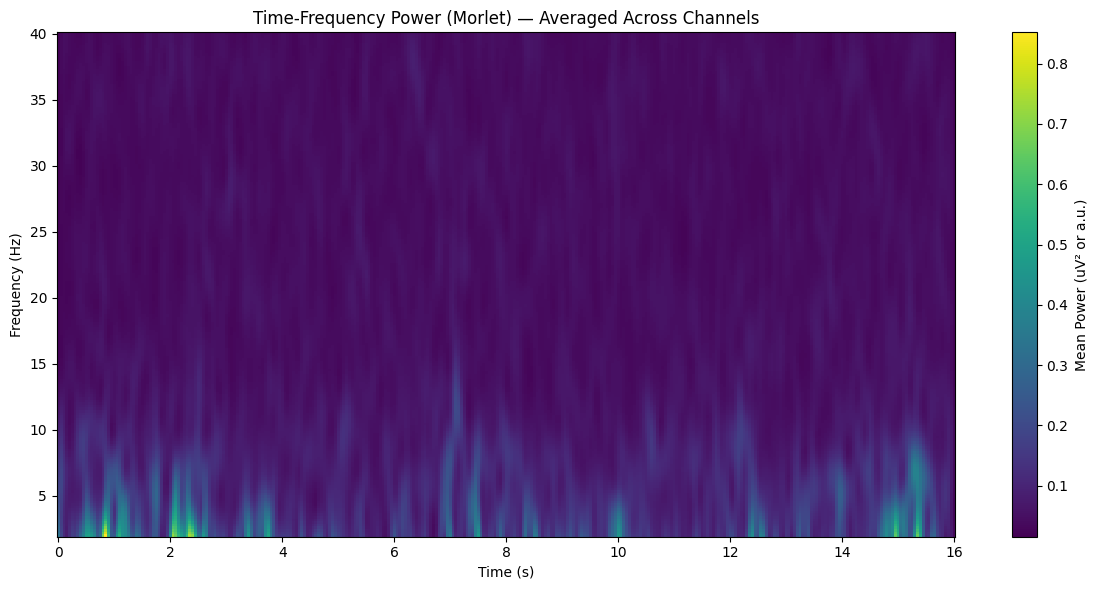

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Получаем массив спектра мощности (n_channels, n_freqs, n_times)
power_all = results_arr[0][0]

# Усредняем по каналам (ось 0) -> (n_freqs, n_times)
power_data = power_all.mean(axis=0)

# Оси
freqs = np.linspace(2, 40, power_data.shape[0])  # 160 частот
times = np.arange(power_data.shape[1]) * decim / 1000

# Визуализация
plt.figure(figsize=(12, 6))
plt.pcolormesh(times, freqs, power_data, shading='auto', cmap='viridis')
plt.colorbar(label='Mean Power (uV² or a.u.)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Time-Frequency Power (Morlet) — Averaged Across Channels')
plt.tight_layout()
plt.show()